In [129]:
import pandas as pd
import numpy as np
import sqlite3
import scipy.stats as stats

from datetime import datetime

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Combine and Tidy Data Sources

In [9]:
djia = pd.read_csv("data/^DJI.csv")
confirmed = pd.read_csv("data/time_series_19-covid-Confirmed.csv")
deaths = pd.read_csv("data/time_series_19-covid-Deaths.csv")
recovered = pd.read_csv("data/time_series_19-covid-Recovered.csv")

In [10]:
djia = djia[djia['Date'] >= '2020-01-01']
djia['Date']=djia['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [11]:
with sqlite3.connect('data/newspaper.db') as conn:
    articles = pd.read_sql("""
                            SELECT * FROM articles
                            WHERE date NOT NULL
                            AND text NOT NULL
                            """, conn)

In [12]:
articles['date'] = articles['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
articles = articles[articles['date'] >= datetime(2020,1,1)]

In [13]:
# tidy 3 dfs
melt_ids = ['Province/State', 'Country/Region', 'Lat', 'Long']

tidy_confirmed = confirmed.melt(id_vars=melt_ids, 
                               value_vars=[c for c in confirmed.columns \
                                           if c not in ['Province/State', 'Country/Region', 'Lat', 'Long']], 
                               var_name='Date', value_name='Confirmed')

tidy_deaths = deaths.melt(id_vars=melt_ids, 
                               value_vars=[c for c in confirmed.columns \
                                           if c not in ['Province/State', 'Country/Region', 'Lat', 'Long']], 
                               var_name='Date', value_name='Deaths')

tidy_recovered = recovered.melt(id_vars=melt_ids, 
                                value_vars=[c for c in confirmed.columns \
                                           if c not in ['Province/State', 'Country/Region', 'Lat', 'Long']], 
                                var_name='Date', value_name='Recovered')


# merge 3 dfs
melt_ids.append('Date')
df = pd.merge(pd.merge(tidy_confirmed, tidy_deaths, on=melt_ids), 
                         tidy_recovered, on=melt_ids)

# tidy merged df
tidy_df = df.melt(id_vars=melt_ids, 
                  value_vars=['Confirmed', 'Deaths', 'Recovered'],
                  var_name='Type', 
                  value_name='Count')

# format date col
tidy_df['Date']=tidy_df['Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))

In [14]:
tidy_df.sample(5)

,Province/State,Country/Region,Lat,Long,Date,Type,Count
25038,South Australia,Australia,-34.9285,138.6007,2020-02-10,Recovered,0
328,NaN,Iceland,64.9631,-19.0208,2020-01-23,Confirmed,0
27420,Grand Princess Cruise Ship,US,37.6489,-122.6655,2020-02-20,Recovered,0
30558,"Douglas County, NE",US,41.3148,-96.1951,2020-03-05,Recovered,0
24587,NaN,Spain,40.0000,-4.0000,2020-02-08,Recovered,0


In [15]:
djia.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume
211,2020-01-08,28556.140625,28866.179688,28522.509766,28745.089844,28745.089844,291750000
222,2020-01-24,29230.390625,29288.789063,28843.310547,28989.730469,28989.730469,380010000
238,2020-02-18,29282.779297,29330.160156,29116.810547,29232.189453,29232.189453,256600000
245,2020-02-27,26526.000000,26775.310547,25752.820313,25766.640625,25766.640625,664980000
225,2020-01-29,28820.529297,28944.240234,28728.189453,28734.449219,28734.449219,302290000


In [16]:
articles.sample(5)

,site,link,title,authors,date,text
1366,nytimes,https://www.nytimes.com/2020/02/22/world/asia/...,‘We’re in a Petri Dish’: How a Coronavirus Rav...,Motoko Rich,2020-02-22,More than three days passed before Japan impo...
2182,nytimes,https://www.nytimes.com/reuters/2020/02/27/spo...,Coronavirus Poses a Logistical Headache for F1...,None,2020-02-27,Advertisement Supported by By Reuters LONDON ...
3459,nytimes,https://www.nytimes.com/reuters/2020/03/03/wor...,Any U.S. Citizen Can Be Tested for Coronavirus...,None,2020-03-03,Advertisement Supported by By Reuters WASHING...
3153,cnn,https://www.cnn.com/2020/03/05/business/costco...,Costco says it's getting a lift from coronavir...,"Nathaniel Meyersohn, Cnn Business",2020-03-05,The company said Thursday that sales at its st...
815,cnn,https://www.cnn.com/2020/01/25/health/coronavi...,Stores in central Texas are running out of med...,Leah Asmelash,2020-01-25,"Stores around the Brazos Valley, where the uni..."


## Questions to Answer

1. Has the news become more negative regarding Coronavirus?
2. Are some news outlets more negative than others when it comes to Coronavirus?
3. Did sentiment in the news cause the large sell-off in the stock market?
4. Was there a tipping point in the number of cases that caused the large sell-off in the stock market?

### 1. Has the news become more negative regarding Coronavirus?

In [17]:
from textblob import TextBlob

In [18]:
def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

In [19]:
articles['sentiment'] = articles['text'].apply(sentiment_analysis)

In [47]:
color_map = {'cnn':'red', 'nytimes':'blue'}

In [48]:
px.histogram(articles, x='sentiment', color='site', color_discrete_map=color_map)

In [21]:
articles['sentiment'].describe()

count    4525.000000
mean        0.071624
std         0.067119
min        -0.325000
25%         0.033542
50%         0.069278
75%         0.107618
max         0.533333
Name: sentiment, dtype: float64

In [22]:
import statsmodels.api as sm 

In [23]:
sm.qqplot(articles['sentiment'], line ='s') 

<Figure size 640x480 with 1 Axes>

In [49]:
px.scatter(articles, x='date', y='sentiment', color='site', color_discrete_map={'cnn':'red', 'nytimes':'blue'})

In [25]:
def subjectivity_analysis(text):
    return TextBlob(text).sentiment.subjectivity

In [30]:
articles['subjectivity'] = articles['text'].apply(subjectivity_analysis)

In [50]:
px.histogram(articles, x='subjectivity', color='site', color_discrete_map={'cnn':'red', 'nytimes':'blue'})

In [32]:
articles['subjectivity'].describe()

count    4525.000000
mean        0.393692
std         0.089424
min         0.000000
25%         0.348785
50%         0.394713
75%         0.439547
max         1.000000
Name: subjectivity, dtype: float64

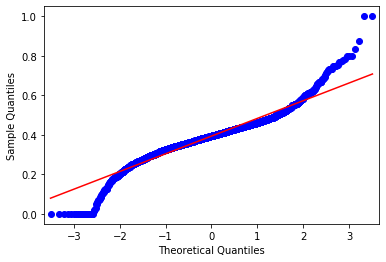

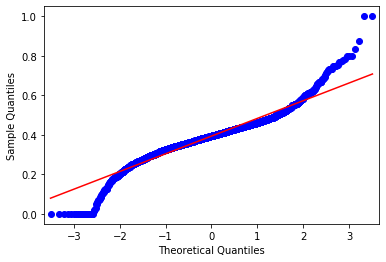

In [33]:
sm.qqplot(articles['subjectivity'], line ='s') 

In [51]:
px.scatter(articles, x='date', y='subjectivity', color='site', color_discrete_map={'cnn':'red', 'nytimes':'blue'})

In [41]:
# counts by country/region
tidy_df = tidy_df.drop(['Lat', 'Long'],axis=1).groupby(['Country/Region', 'Type', 'Date']).sum().reset_index()

# counts by US/Non-US
tidy_df['US'] = tidy_df['Country/Region'] == 'US'
tidy_df['US'].replace(True, 'US', inplace=True)
tidy_df['US'].replace(False, 'Non-US', inplace=True)
tidy_df = tidy_df.groupby(['US', 'Date', 'Type']).sum().reset_index()

# px.scatter(tidy_df[tidy_df['Country/Region']=='US'], x='Date', y='Count', color='Type')

In [53]:
px.scatter(tidy_df[tidy_df['US']=='US'], x='Date', y='Count', color='Type')

In [45]:
px.scatter(djia, x='Date', y='Adj Close')

#### Press Plots

In [107]:
# cnn = articles[articles['site']=='cnn']
# nytimes = articles[articles['site']=='nytimes']

# fig = make_subplots(rows=6, cols=1, shared_xaxes=True)

# fig.add_trace(
#     go.Scatter(
#         x=cnn['date'],
#         y=cnn['sentiment'],
#         mode="markers",
#         marker=dict(color='red')
#     ),
#     row=1, col=1
# )
# fig.add_trace(
#     go.Scatter(
#         x=nytimes['date'],
#         y=nytimes['sentiment'],
#         mode="markers",
#         marker=dict(color='blue')
#     ),
#     row=2, col=1
# )
# fig.add_trace(
#     go.Scatter(
#         x=tidy_df[(tidy_df['US']=='US')&(tidy_df['Type']=='Confirmed')]['Date'],
#         y=tidy_df[(tidy_df['US']=='US')&(tidy_df['Type']=='Confirmed')]['Count'],
#         mode="markers",
#     ),
#     row=3, col=1
# )
# fig.add_trace(
#     go.Scatter(
#         x=tidy_df[(tidy_df['US']=='Non-US')&(tidy_df['Type']=='Confirmed')]['Date'],
#         y=tidy_df[(tidy_df['US']=='Non-US')&(tidy_df['Type']=='Confirmed')]['Count'],
#         mode="markers",
#     ),
#     row=4, col=1
# )
# fig.add_trace(
#     go.Scatter(
#         x=tidy_df[(tidy_df['US']=='US')&(tidy_df['Type']=='Deaths')]['Date'],
#         y=tidy_df[(tidy_df['US']=='US')&(tidy_df['Type']=='Deaths')]['Count'],
#         mode="markers",
#     ),
#     row=5, col=1
# )
# fig.add_trace(
#     go.Scatter(
#         x=tidy_df[(tidy_df['US']=='Non-US')&(tidy_df['Type']=='Deaths')]['Date'],
#         y=tidy_df[(tidy_df['US']=='Non-US')&(tidy_df['Type']=='Deaths')]['Count'],
#         mode="markers",
#     ),
#     row=6, col=1
# )


# fig.update_layout(height=1500, width=1000, title_text="", showlegend=False)
# fig.update_yaxes(title_text="Sentiment of NY Times Articles", row=1, col=1)
# fig.update_yaxes(title_text="Sentiment of CNN Articles", row=2, col=1)
# fig.update_yaxes(title_text="Confirmed Cases (US)", row=3, col=1)
# fig.update_yaxes(title_text="Confirmed Cases (Non-US)", row=4, col=1)
# fig.update_yaxes(title_text="Death Cases (US)", row=5, col=1)
# fig.update_yaxes(title_text="Death Cases (Non-US)", row=6, col=1)
# fig.show()

In [102]:
px.scatter(articles, x='date', y='subjectivity', color='site', color_discrete_map={'cnn':'red', 'nytimes':'blue'})

In [104]:
cnn = articles[articles['site']=='cnn']
nytimes = articles[articles['site']=='nytimes']

fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# make subplots 
fig.add_trace(
    go.Scatter(
        x=cnn['date'],
        y=cnn['sentiment'],
        mode="markers",
        marker=dict(color='red')
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=nytimes['date'],
        y=nytimes['sentiment'],
        mode="markers",
        marker=dict(color='blue')
    ),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(
        x=tidy_df[(tidy_df['US']=='US')&(tidy_df['Type']=='Confirmed')]['Date'],
        y=tidy_df[(tidy_df['US']=='US')&(tidy_df['Type']=='Confirmed')]['Count'],
        mode="markers",
        marker=dict(color='green')
    ),
    row=3, col=1
)

# configure plot
fig.update_layout(height=1200, width=1000, title_text="here", showlegend=False)

fig.update_yaxes(title_text="Sentiment of NY Times Articles", row=1, col=1)
fig.update_yaxes(title_text="Sentiment of CNN Articles", row=2, col=1)
fig.update_yaxes(title_text="Confirmed Cases (US)", row=3, col=1)

# display
fig.show()

In [146]:
sentiment = articles.groupby(['site', 'date'])['sentiment'].describe().reset_index()[['site', 'date', 'mean', 'std', 'count']]

In [151]:
cnn_sentiment = sentiment[sentiment['site']=='cnn']
nytimes_sentiment = sentiment[sentiment['site']=='nytimes']

fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# make subplots 
fig.add_trace(
    go.Scatter(
        x=cnn_sentiment['date'],
        y=cnn_sentiment['std'],
        mode="markers",
        marker=dict(color='red')
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=nytimes_sentiment['date'],
        y=nytimes_sentiment['std'],
        mode="markers",
        marker=dict(color='blue')
    ),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(
        x=tidy_df[(tidy_df['US']=='US')&(tidy_df['Type']=='Confirmed')]['Date'],
        y=tidy_df[(tidy_df['US']=='US')&(tidy_df['Type']=='Confirmed')]['Count'],
        mode="markers",
        marker=dict(color='green')
    ),
    row=3, col=1
)

# configure plot
fig.update_layout(height=1200, width=1000, title_text="here", showlegend=False)

fig.update_yaxes(title_text="StDev of Sentiment of NY Times Articles", row=1, col=1)
fig.update_yaxes(title_text="StDev of Sentiment of CNN Articles", row=2, col=1)
fig.update_yaxes(title_text="Confirmed Cases (US)", row=3, col=1)

# display
fig.show()

In [137]:
# alpha = 0.05

# sentiment['upper_bound'] = sentiment['mean'] + stats.t.ppf(1-(alpha/2), df=sentiment['count']-1)*sentiment['std']/np.sqrt(sentiment['count'])
# sentiment['lower_bound'] = sentiment['mean'] - stats.t.ppf(1-(alpha/2), df=sentiment['count']-1)*sentiment['std']/np.sqrt(sentiment['count'])

# sentiment = sentiment[sentiment['site']=='nytimes']

# upper_bound = go.Scatter(
#     name='Upper Bound',
#     x=sentiment['date'],
#     y=sentiment['upper_bound'],
#     mode='lines',
#     marker=dict(color="#444"),
#     line=dict(width=0),
#     fillcolor='rgba(68, 68, 68, 0.3)',
#     fill='tonexty')

# trace = go.Scatter(
#     name='Measurement',
#     x=sentiment['date'],
#     y=sentiment['mean'],
#     mode='lines',
#     line=dict(color='rgb(31, 119, 180)'),
#     fillcolor='rgba(68, 68, 68, 0.3)',
#     fill='tonexty')

# lower_bound = go.Scatter(
#     name='Lower Bound',
#     x=sentiment['date'],
#     y=sentiment['lower_bound'],
#     marker=dict(color="#444"),
#     line=dict(width=0),
#     mode='lines')

# # Trace order can be important
# # with continuous error bars
# data = [lower_bound, trace, upper_bound]

# layout = go.Layout(
#     yaxis=dict(title='Wind speed (m/s)'),
#     title='Continuous, variable value error bars.<br>Notice the hover text!',
#     showlegend = False)

# fig = go.Figure(data=data, layout=layout)
# fig.show()